# Natural Language Processing with Disaster Tweets
---------------------------------------------

# 1. Description of the project 

### Twitter(X)'s Authenticity Crisis as a Communication Tool or Media:

- Role of Twitter in Emergencies: Twitter has emerged as a vital real-time communication platform during crises due to widespread smartphone use.

- Challenges in Interpretation: Distinguishing between literal and metaphorical language (e.g., the use of "IT WAS ABLAZE" metaphorically) is straightforward for humans but challenging for machines.

- Devise a machine learning model to classify tweets as disaster-related or not, using a dataset of 10,000 hand-classified tweets.

### Details:
- Dataset: Comprises 10,000 tweets, providing a basis for training and testing the model.
  
- Objective: Improve real-time disaster response by accurately identifying genuine emergency communications on Twitter (X).

# 2. EDA (exploratory data analysis)

#### *Required libraries

In [103]:
!pip install transformers -q
!pip install wordcloud -q
!pip install transformers datasets torch -q
!pip install torch torchvision torchaudio -q


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [104]:
import os
import gc
gc.enable()
import time
import warnings
warnings.filterwarnings("ignore")
import re
import string
import operator
import urllib.request
import zipfile

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from transformers import BertForSequenceClassification
from transformers import BertModel
from transformers import AutoTokenizer, BertTokenizer, BertForSequenceClassification, DataCollatorWithPadding

import torch
from torch.optim import AdamW
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from datasets import load_dataset
from wordcloud import STOPWORDS

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, GroupKFold, train_test_split, GroupShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
from datasets import load_dataset

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

#### *Reproductivity

In [105]:
def set_seed(seed):
    import random
    SEED=seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [106]:
# Check and set device (using GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


#### *Read CSV

In [107]:
df_trn = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

#### *Remove Data Duplication

In [108]:
df_train = df_trn.drop_duplicates(subset='text', keep='first')

# Check
print(f"Original dataset size: {len(df_trn)}")
print(f"After removing duplication: {len(df_train)}")

Original dataset size: 7613
After removing duplication: 7503


#### *Check Mislabeled Data

In [109]:
df_invalid_target = df_train[~df_train['target'].isin([0, 1])]
print("Mislabeled Data:  ", len(df_invalid_target))

Mislabeled Data:   0


#### Dataset Size & Structure

In [110]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7503, 5)
Training Set Memory Usage = 0.34 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [111]:
print("Training Set Structure >>>>> \n")
print(df_train.info(), "\n")
df_train.head()

Training Set Structure >>>>> 

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7503 non-null   int64 
 1   keyword   7447 non-null   object
 2   location  5021 non-null   object
 3   text      7503 non-null   object
 4   target    7503 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 351.7+ KB
None 



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [112]:
print("Test Set Structure >>>>> \n")
print(df_test.info(), "\n")
df_test.head()

Test Set Structure >>>>> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None 



,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 'Keywords' and 'Location' - missing value

- **0.01%** of `keyword` is missing in both training and test set
- **33%** of `location` is missing in both training and test set

Missing value in `keyword`  and `location`  are found in the same ratio in the training and the test datasets.  Missing values in those features are filled with `no_keyword` and `no_location` respectively.

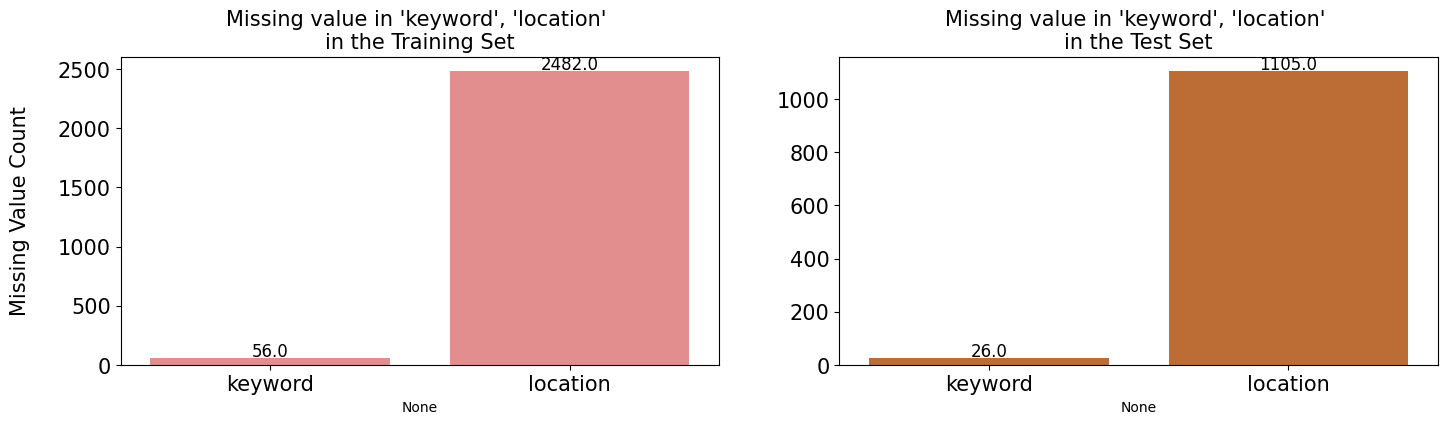

In [113]:
# Missing value in 'keyword', 'location'
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

# Training Set
sns.barplot(x=df_train[missing_cols].isnull().sum().index, 
            y=df_train[missing_cols].isnull().sum().values, 
            ax=axes[0],
            palette=['lightcoral'])   

# 각 막대 위에 값 추가 (Training Set)
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     fontsize=12, color='black', 
                     xytext=(0, 5), textcoords='offset points')

# Test Set
sns.barplot(x=df_test[missing_cols].isnull().sum().index, 
            y=df_test[missing_cols].isnull().sum().values, 
            ax=axes[1],
            palette=['chocolate'])   

# 각 막대 위에 값 추가 (Test Set)
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     fontsize=12, color='black', 
                     xytext=(0, 5), textcoords='offset points')

# 설정
axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title("Missing value in 'keyword', 'location' \nin the Training Set", fontsize=15)
axes[1].set_title("Missing value in 'keyword', 'location' \nin the Test Set", fontsize=15)

plt.show()

In [114]:
# Flling the missing value with no_ 
for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no {col} ')


In [49]:
df_train.head()

,id,keyword,location,text,target
0,1,no keyword,no location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no keyword,no location,Forest fire near La Ronge Sask. Canada,1
2,5,no keyword,no location,All residents asked to 'shelter in place' are ...,1
3,6,no keyword,no location,"13,000 people receive #wildfires evacuation or...",1
4,7,no keyword,no location,Just got sent this photo from Ruby #Alaska as ...,1


In [115]:
# Simple Stats
df_train.describe()

,id,target
count,7503.000000,7503.000000
mean,5439.831401,0.426230
std,3141.748725,0.494561
min,1.000000,0.000000
25%,2726.500000,0.000000
50%,5408.000000,0.000000
75%,8149.500000,1.000000
max,10873.000000,1.000000


## 'Keywords' and 'Location' - unique values

- ### Locations are not automatically generated, and just user inputs.  As they have too many unique values, it's not proper to use as a feature.

- ### However, as `keywords` are generally used in the consistent context, we can consider `keyword` as a feature for distinguish these dialogues are happening under the urgent situation or not. 

- ### We can use target encoding on `keyword`.  But at the same time, even though target encoding is a promising way to improve model performance, but it requires proper measures to prevent overfitting. This can improve the generalization ability of the model.

In [116]:
print(f'Number of unique values in keyword >> {df_train["keyword"].nunique()} (training), {df_test["keyword"].nunique()} (test)')
print(f'Number of unique values in location >> {df_train["location"].nunique()} (training), {df_test["location"].nunique()} (test)')

# Extract all unique keywords from the training set
train_keywords = set(df_train['keyword'].unique())

# Extract all unique keywords from the test set
test_keywords = set(df_test['keyword'].unique())

# Check if all keywords from the training set are included in the test set
all_train_keywords_in_test = train_keywords.issubset(test_keywords)

print(f"Q. Are all training set keywords included in the test set? >>>  {all_train_keywords_in_test}")

# If there are any keywords not included, print those keywords
if not all_train_keywords_in_test:
    missing_keywords = train_keywords - test_keywords
    print("Keywords present in the training set but not in the test set:", missing_keywords)
else:
    print("> All keywords are present in the test set.")

Number of unique values in keyword >> 222 (training), 222 (test)
Number of unique values in location >> 3328 (training), 1603 (test)
Q. Are all training set keywords included in the test set? >>>  True
> All keywords are present in the test set.


## Exploring class imbalance 

- In the dataset, the ratio of disaster (1) and non-disaster (0) is 43:57, which means there is a class imbalance.
- This increases the possibility that the disaster class (minority class) will not be sufficiently learned during model learning, resulting in a decrease in performance (especially F1-Score, Recall).
- To solve this, we plan to apply a method to handle class imbalance. (Applying class weights or Focal Loss)

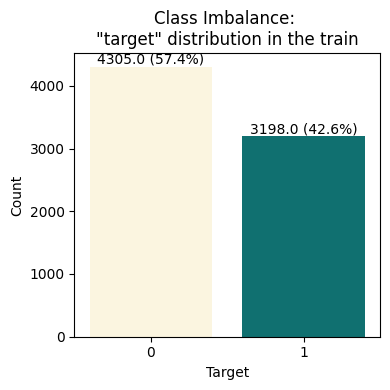

In [117]:
# explore class imbalance
target_counts = df_train['target'].value_counts()
total_counts = target_counts.sum()

target_percentages = (target_counts / total_counts) * 100


plt.figure(figsize=(4, 4))

colors = ['#FFF8DC', '#008080']   
# countplot 생성
ax = sns.countplot(x='target', data=df_train, palette=colors)

# 비율 라벨 추가
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height} ({target_percentages[p.get_x() + p.get_width() / 2]:.1f}%)',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.title('Class Imbalance: \n"target" distribution in the train')
plt.xlabel('Target')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Target Distribution by Keyword

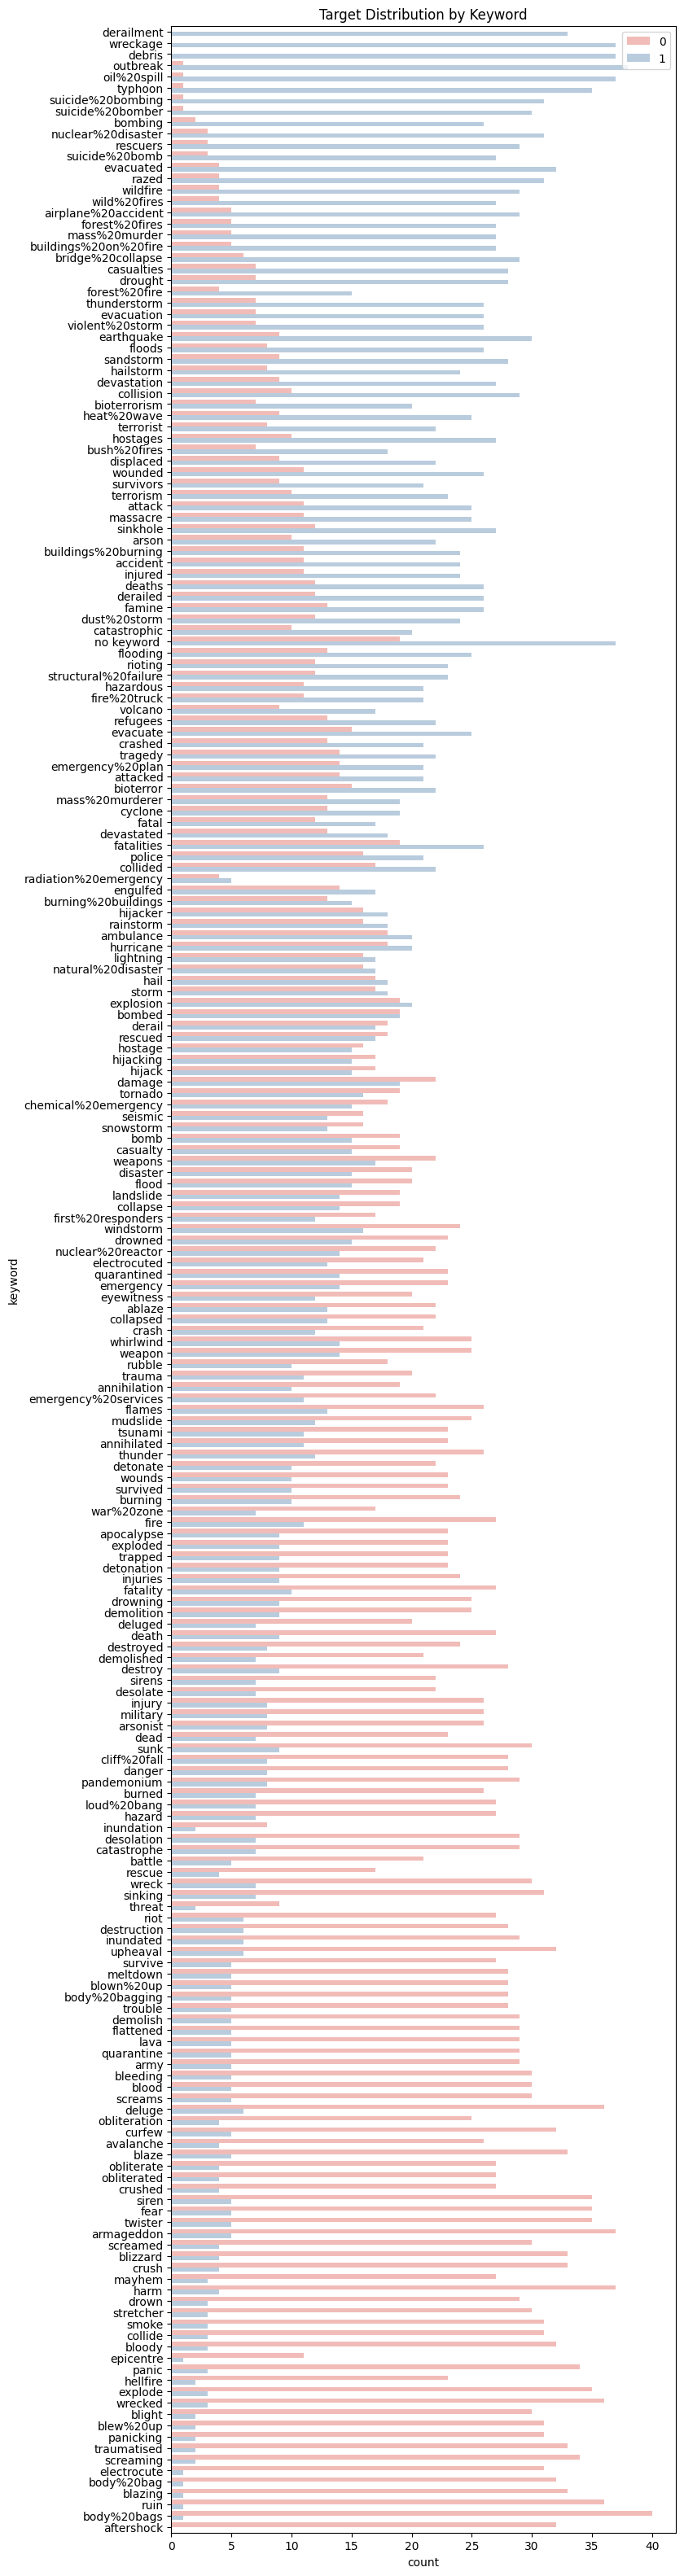

In [118]:
# Plot Target Distribution by Keyword
df_train['keyword_target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
fig = plt.figure(figsize=(8, 40), dpi=100)

sns.countplot(y=df_train.sort_values(by='keyword_target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='keyword_target_mean', ascending=False)['target'], 
              palette='Pastel1')

plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.legend(loc=1)
plt.title('Target Distribution by Keyword')
plt.show()

# Delete 'keyword_target_mean' column
df_train.drop(columns=['keyword_target_mean'], inplace=True)

## Target Distributions by Statistics on Text

Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. At the first look, disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The followings are meta features that are expected to be useful:

* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text

#### *Distribution of text

In [120]:
# Statistics on Text
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(
    lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(
    lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(
    lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(
    lambda x: len([c for c in str(x) if c in string.punctuation]))

## Visualization for Statistics Feature

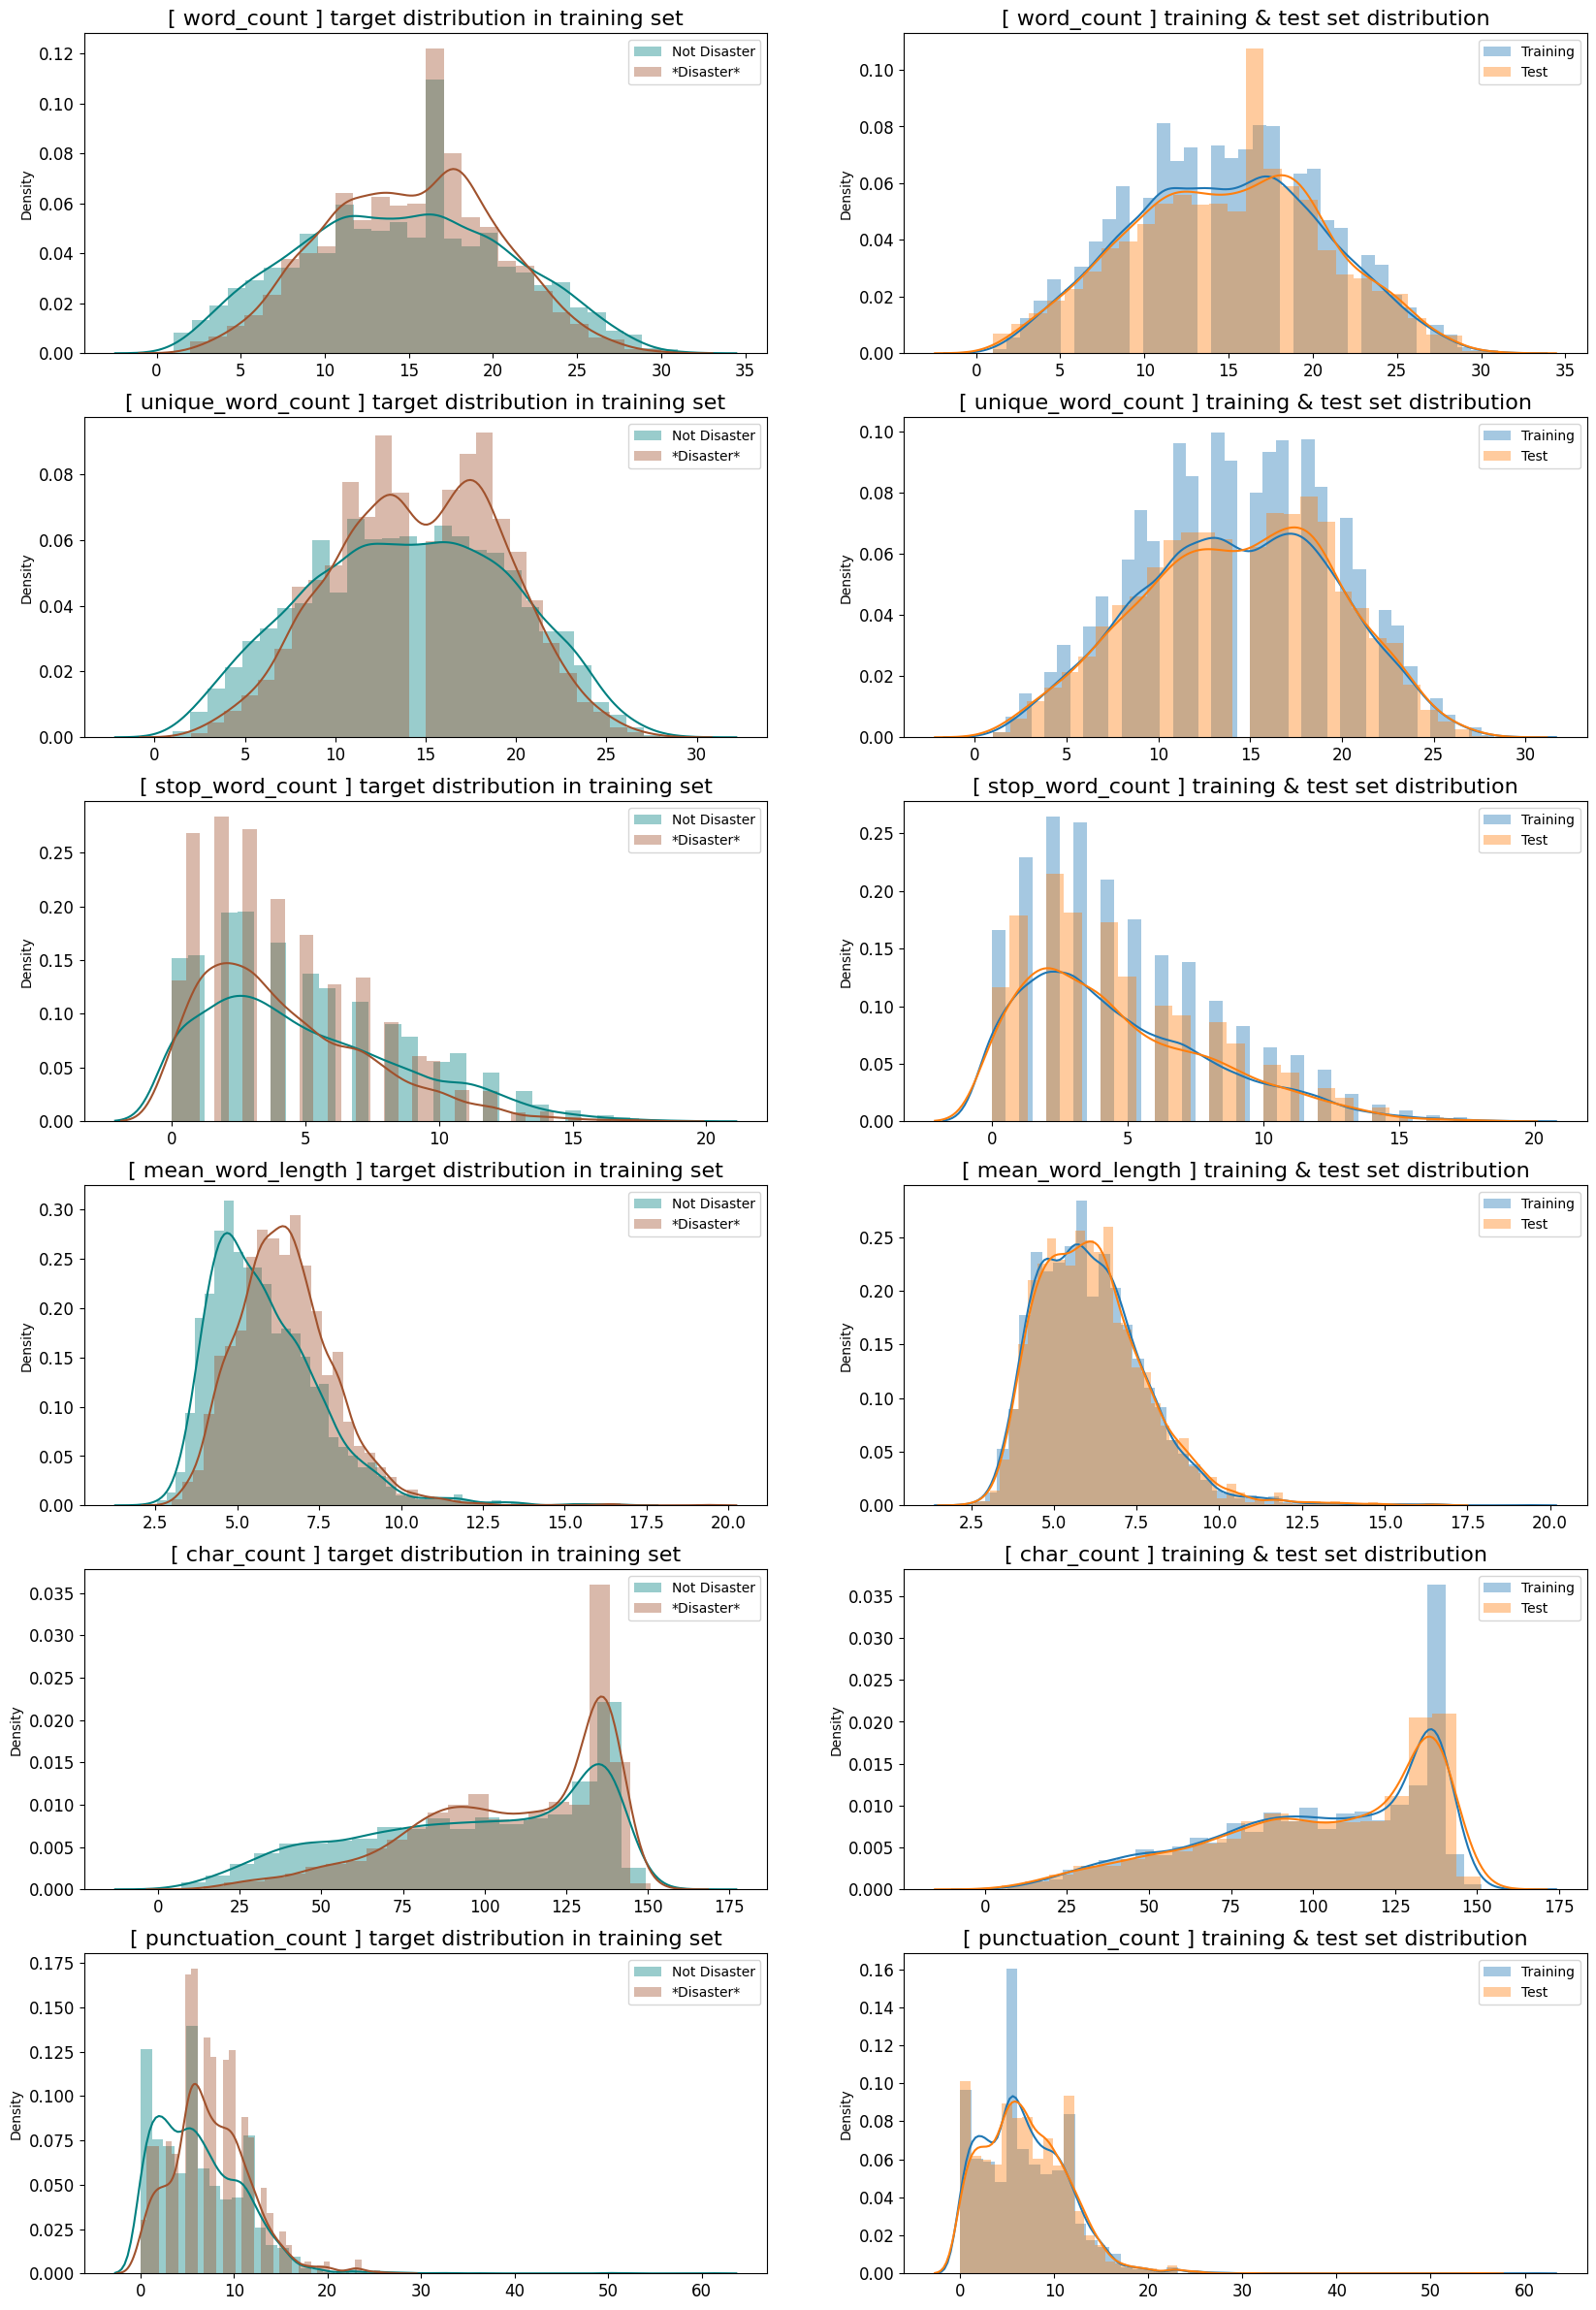

In [121]:
# Plot Statistics Fearue
STATS_FEATURE = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length',
                'char_count', 'punctuation_count']

DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(STATS_FEATURE), figsize=(20, 30), dpi=100)

for i, feature in enumerate(STATS_FEATURE):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label = 'Not Disaster', 
                 ax=axes[i][0], color='teal')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label = '*Disaster*', 
                 ax=axes[i][0], color='sienna')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'[ {feature} ] target distribution in training set',fontsize=16)
    axes[i][1].set_title(f'[ {feature} ] training & test set distribution',fontsize=16)

plt.show()

## 'N-grams' by Target : unigram, bigram, trigram

Incorporating N-grams by target helps to better understand the context in which words appear and their relationship to the target variable, leading to more accurate models that can recognize nuanced patterns in the data. It allows the model to capture richer information, improving classification of target. Take a look at:

In [122]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') 
             if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 30

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), 
                                           key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), 
                                              key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), 
                                          key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), 
                                             key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), 
                                           key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), 
                                              key=lambda x: x[1])[::-1])

## Unigrams

- The most common unigrams in both classes are $'-'$ and punctuations, stop words, or numbers are found in most common unigram, which don't provide much information about the target. Therefore, it's better to clean them before modeling.

- The most common unigrams in disaster tweets are $'fire'$ that convey information about disasters, making it challenging to use these words in other contexts without exceptional cases.

- In contrast, the most common unigrams in non-disaster tweets are $'will', 'new', 'now' $ that underline the essential part of characteristics of the twitter(X) as a media.


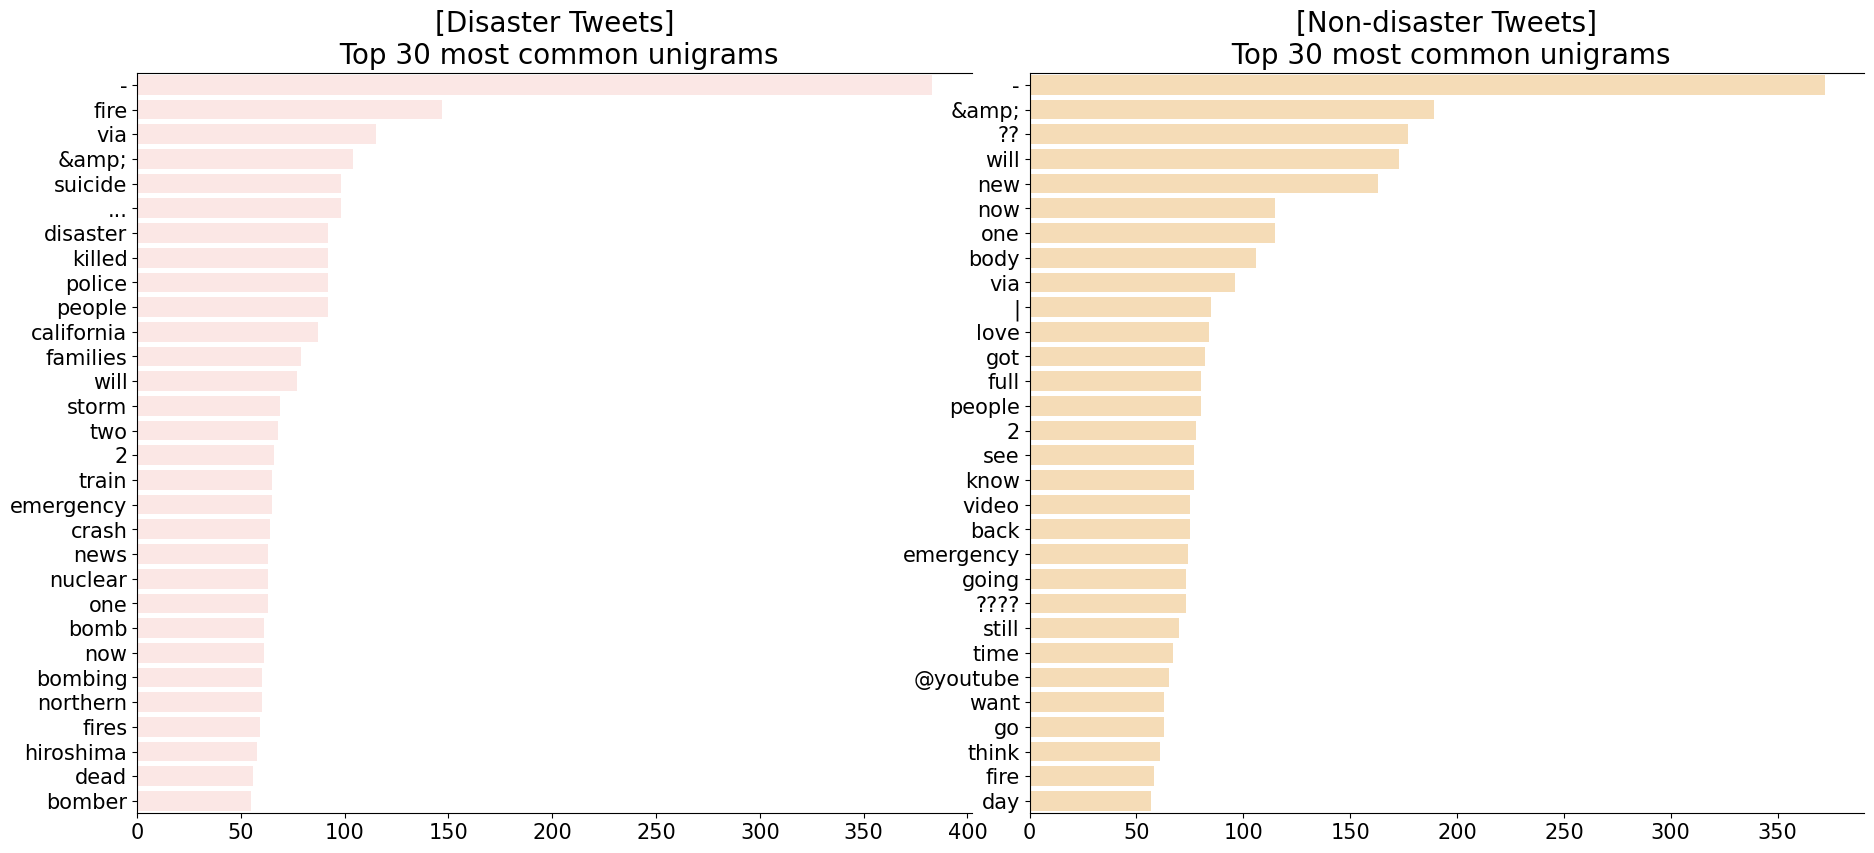

In [123]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 8), dpi=100)
plt.tight_layout()
sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], 
            ax=axes[0], color='mistyrose')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], 
            ax=axes[1], color='navajowhite')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'[Disaster Tweets]\n Top {N} most common unigrams', fontsize=20)
axes[1].set_title(f'[Non-disaster Tweets]\n Top {N} most common unigrams', fontsize=20)

plt.show()

## Bigram

- Due to the clearer context in the Bigrams, there are no common bigrams that exist in both classes.

- The most common bigrams in disaster tweets is 'suicide bomber' provide more information about disasters than unigrams.

- In contrast, the most common bigrams in non-disaster tweets seems to be related to popular contents on YouTube or Reddit and contain a significant number of special character like '@, ? [, ], ...' , which should also be cleaned out of the text.

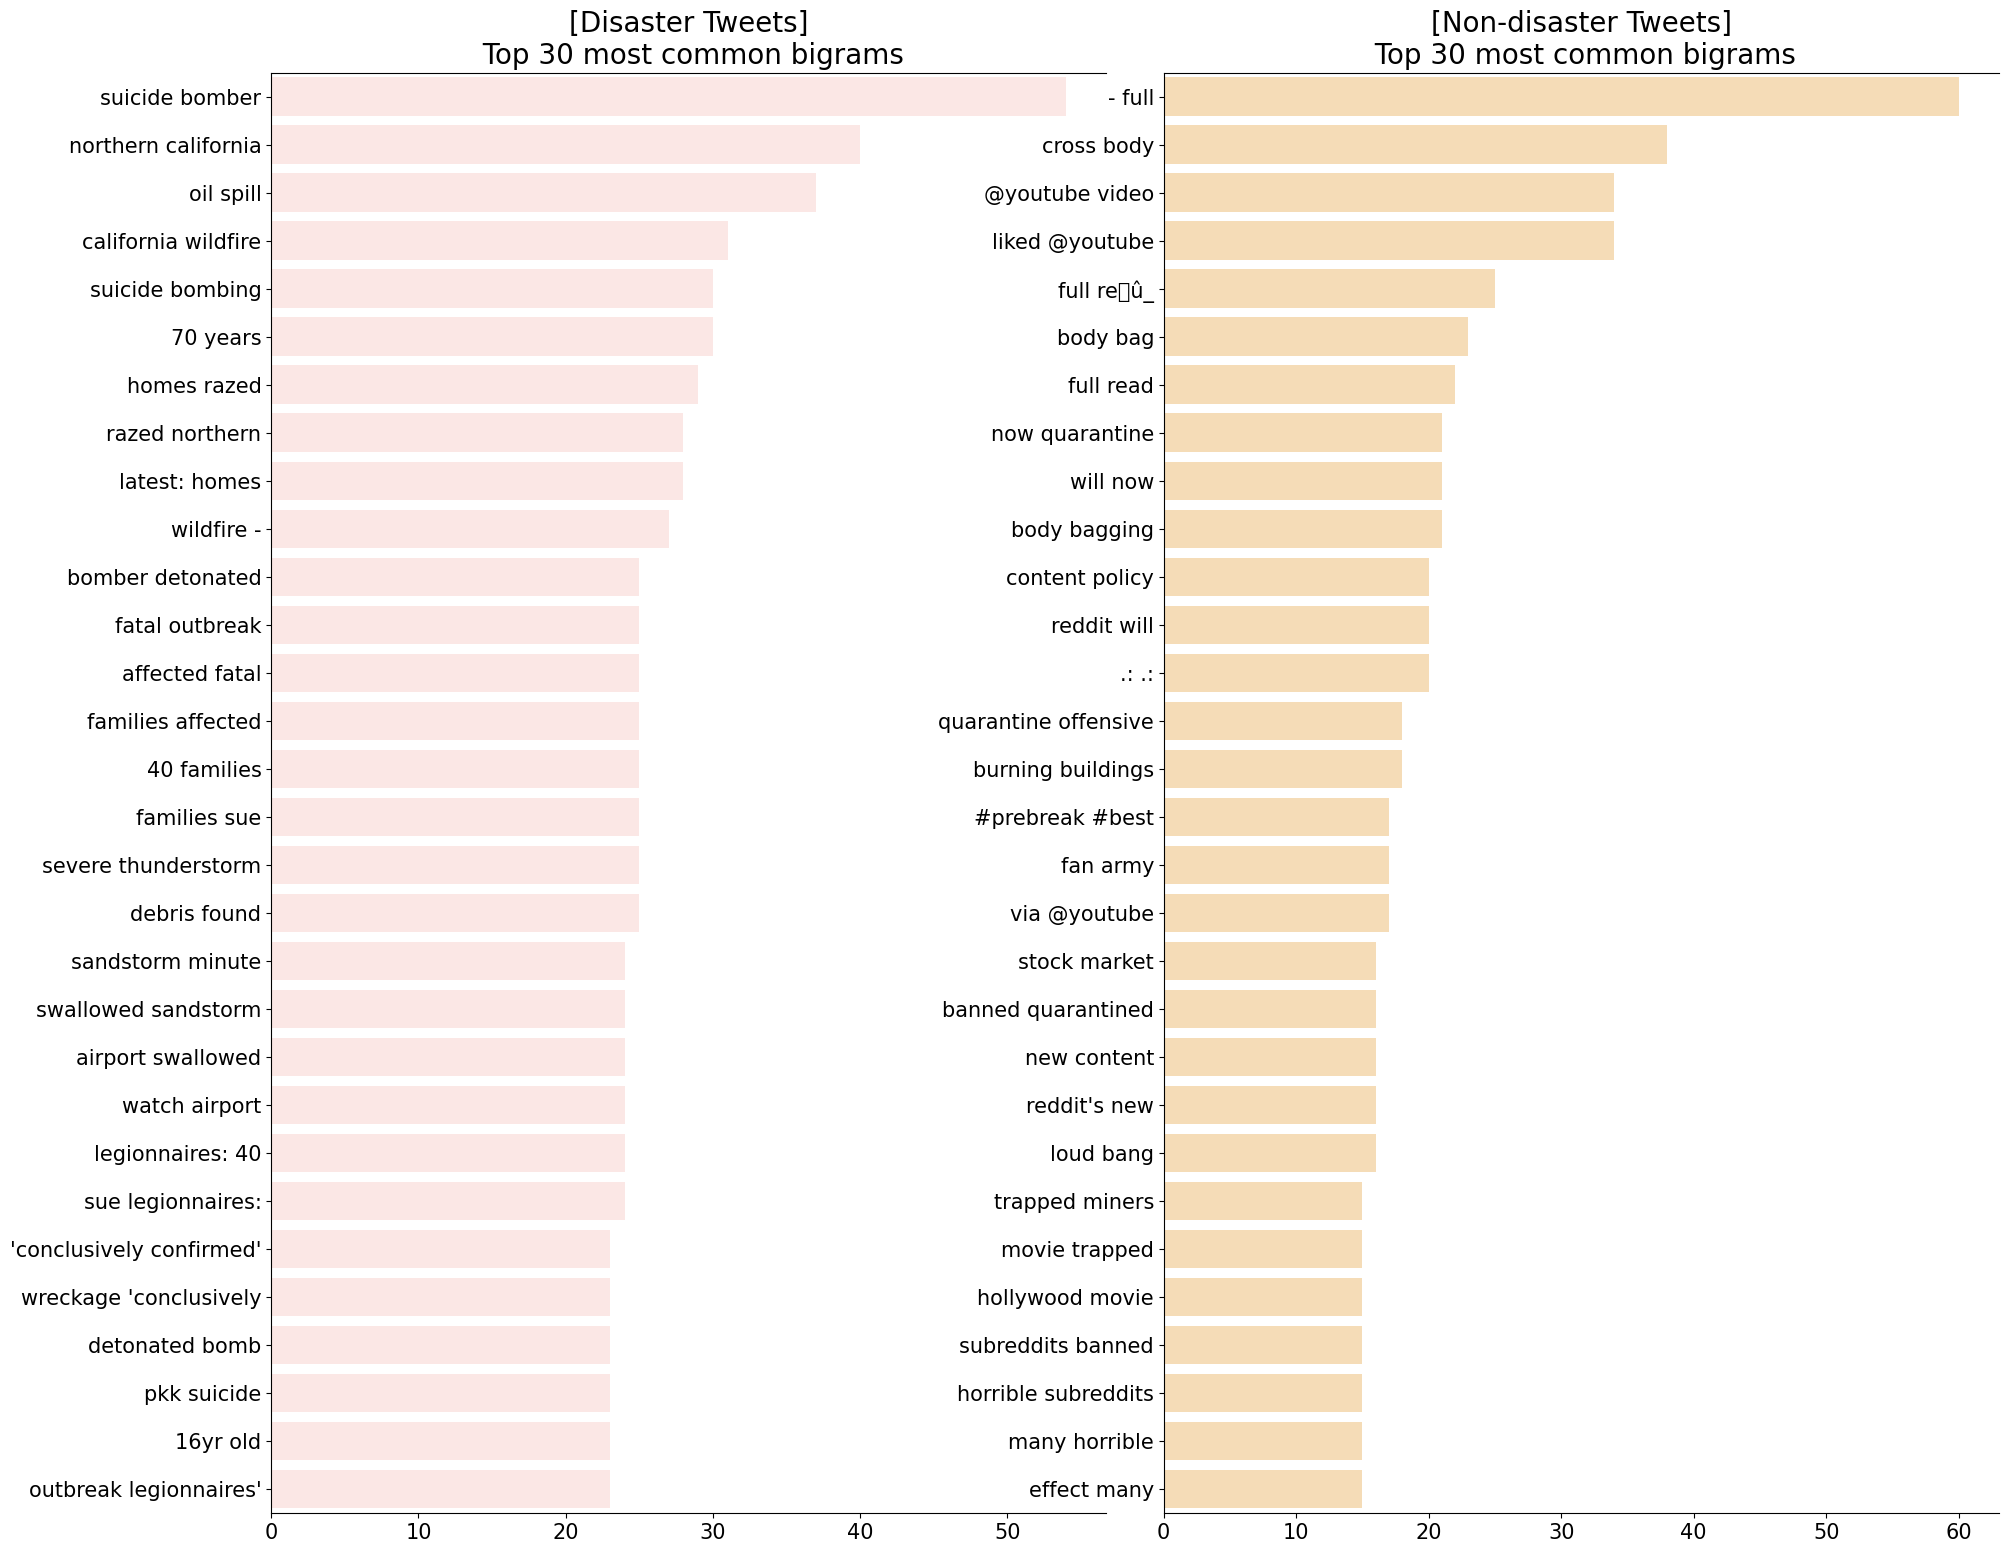

In [124]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 15), dpi=100)
plt.tight_layout()
sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], 
            ax=axes[0], color='mistyrose')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], 
            ax=axes[1], color='navajowhite')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'[Disaster Tweets]\n Top {N} most common bigrams', fontsize=20)
axes[1].set_title(f'[Non-disaster Tweets]\n Top {N} most common bigrams', fontsize=20)

plt.show()

## Trigram

- The most common trigrams in disaster tweets, such as "suicide bomber detonated", are remarkably similar to bigrams and provide substantial information about disasters. However, they may not offer significant additional insights when combined with bigrams.

- Similarly, the most common trigrams in non-disaster tweets are also closely related to bigrams, often containing information about YouTube and special characters, which may not provide distinct value in addition to what is already captured by bigrams.

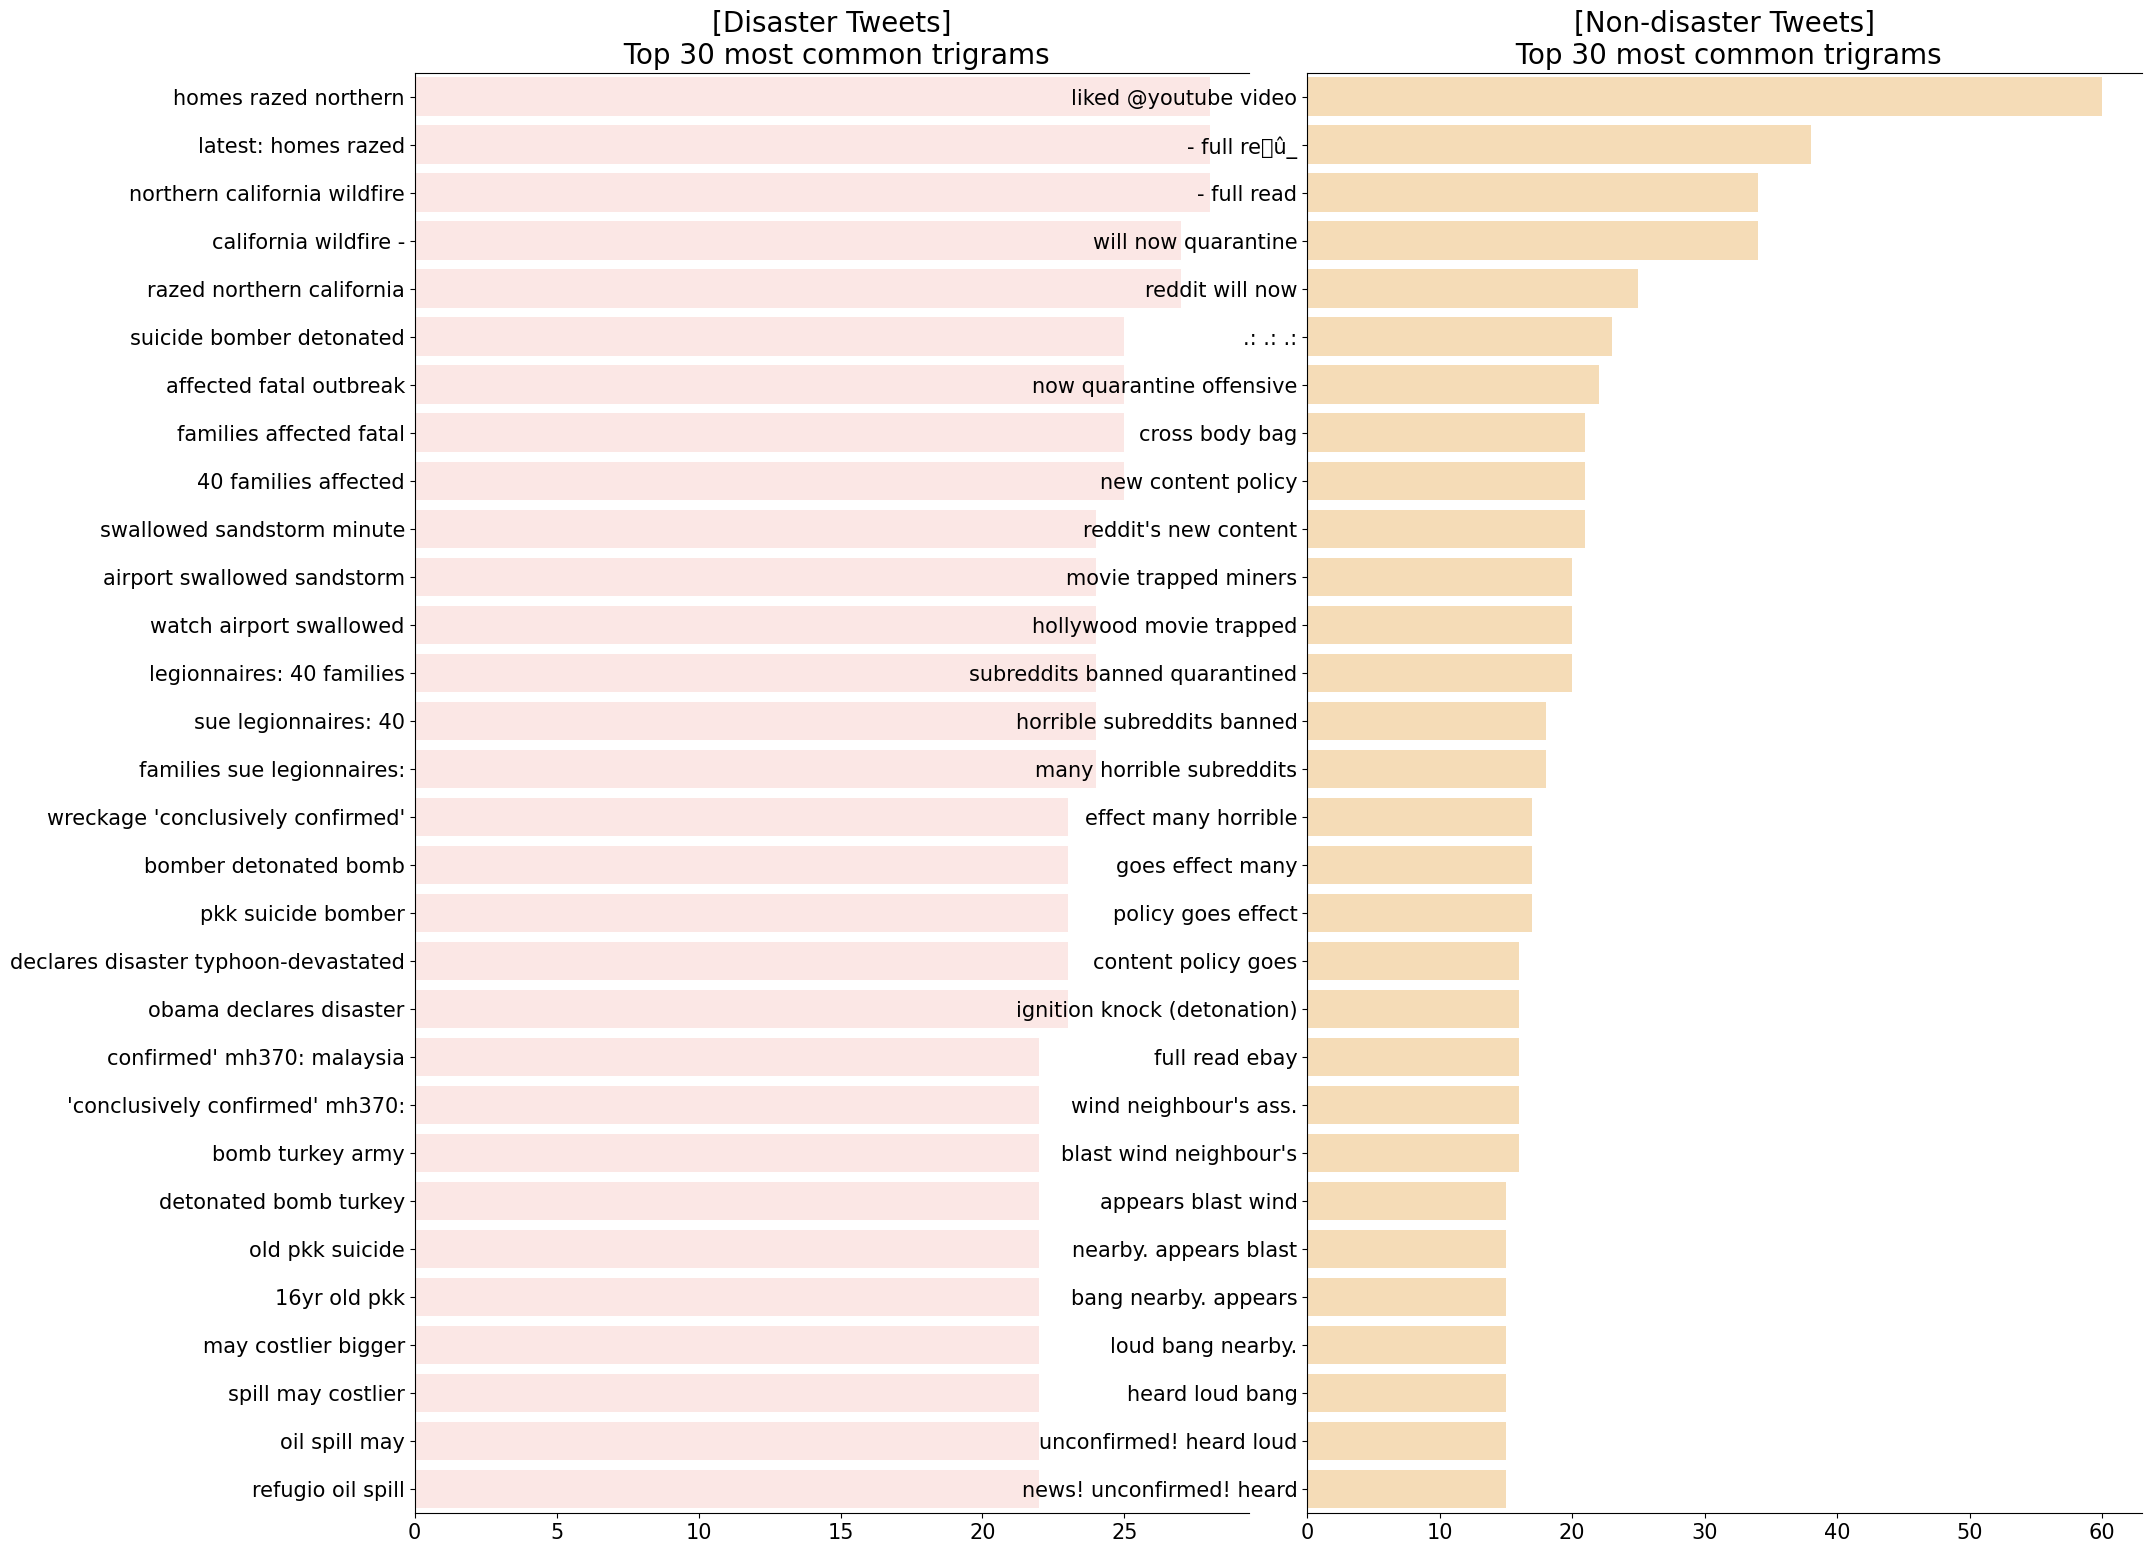

In [125]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 15), dpi=100)
plt.tight_layout()
sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], 
            ax=axes[0], color='mistyrose')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], 
            ax=axes[1], color='navajowhite')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)

axes[0].set_title(f'[Disaster Tweets]\n Top {N} most common trigrams', fontsize=20)
axes[1].set_title(f'[Non-disaster Tweets]\n Top {N} most common trigrams', fontsize=20)

plt.show()

In [126]:
len(df_disaster_trigrams)

23202

## Insight after inspecting N-gram 

Reviewed traditional N-grams, and the result was bigrams and trigrams can capture context and distinguish the target and expected to impove predictive performance.

That's why selected Transformer models, BERT that can capture context much more effectively than traditional N-grams. In fact, one of the key advantages of Transformer models is their ability to learn contextual relationships between words (or tokens) across the entire input sequence, unlike N-grams which only consider local relationships between adjacent words. 

Comparing N-grams and Transformers: 

| Aspect | N-grams | Transformer models |
|----------------------------|----------------------------|----------------------------|
| Context Capture | Local context only (adjacent words) | Global context (any word in the sequence) |
| Handling Long-range Dependencies	| Limited (fixed window size) | Excellent (self-attention mechanism)| 
| Contextual Meaning| 	Can't differentiate ambiguous meanings	| Can capture different meanings based on context| 
| Training Complexity | Simple (but can explode in size with higher N) | More complex (requires large datasets and computational power)| 
| Handling Syntax/Structure	| Limited ability to handle complex syntax	| Excellent at capturing syntactic and semantic structures| 
| Use Case	| Simple tasks with clear local patterns (e.g., topic modeling)	| Complex NLP tasks (e.g., sentiment analysis, translation, summarization)| 


In [127]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 7612
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7503 non-null   int64  
 1   keyword            7503 non-null   object 
 2   location           7503 non-null   object 
 3   text               7503 non-null   object 
 4   target             7503 non-null   int64  
 5   word_count         7503 non-null   int64  
 6   unique_word_count  7503 non-null   int64  
 7   stop_word_count    7503 non-null   int64  
 8   mean_word_length   7503 non-null   float64
 9   char_count         7503 non-null   int64  
 10  punctuation_count  7503 non-null   int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 703.4+ KB
None


# 3. Text Data Cleaning

The below libraries are useful for preprocessing text, especially for NLP tasks involving noisy or social media data.

- tweet-preprocessor – A library for preprocessing and cleaning tweets, such as removing mentions, URLs, hashtags, emojis, and reserved words.
- ekphrasis – A text processing tool designed for social media data. It includes tokenization, spell correction, word segmentation, and more.
- clean-text – A library for cleaning and normalizing text by removing unwanted characters, fixing accents, and handling Unicode issues.
contractions – Expands English contractions (e.g., "don't" → "do not") to improve text clarity.
- emoji – A library for working with emojis, including conversion between text and emoji representations.
- unidecode – Converts Unicode text to ASCII, making non-English characters more readable in a simplified format.


In [128]:
!pip install tweet-preprocessor -q
!pip install ekphrasis -q
!pip install clean-text -q
!pip install contractions -q
!pip install emoji -q
!pip install unidecode -q
print("all multi pip done")


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
all multi pip done


In [129]:
# remove 'location', rename 'text'colum, and add new 'text'colum for data cleaning
df_train.rename(columns={'text': 'b4embedding_text'}, inplace=True)
df_test.rename(columns={'text': 'b4embedding_text'}, inplace=True)

df_train.insert(2, 'text', df_train['b4embedding_text'])
df_test.insert(2, 'text', df_test['b4embedding_text'])

del df_train['location']
del df_test['location']
print(df_train.info(), df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7503 entries, 0 to 7612
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7503 non-null   int64  
 1   keyword            7503 non-null   object 
 2   text               7503 non-null   object 
 3   b4embedding_text   7503 non-null   object 
 4   target             7503 non-null   int64  
 5   word_count         7503 non-null   int64  
 6   unique_word_count  7503 non-null   int64  
 7   stop_word_count    7503 non-null   int64  
 8   mean_word_length   7503 non-null   float64
 9   char_count         7503 non-null   int64  
 10  punctuation_count  7503 non-null   int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 703.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id

In [130]:
df_train['b4embedding_text'][888:898]

895             Bloody insomnia again! Grrrr!! #Insomnia
896    @zhenghxn i tried 11 eyes akame ga kill and to...
897    @Fantosex Now suck it up because that's all yo...
898    You call them weekends. I call them Bloody Mar...
899    Bloody hell what a day. I haven't even really ...
900                                      Damn bloody hot
901                @MrTophyPup it's bloody sexy *drools*
902    You know how they say the side effects low &am...
903    Ronda Rousey would be 'close' to making Floyd ...
904    I'm awful at painting.. why did I agree to do ...
Name: b4embedding_text, dtype: object

In [131]:
import preprocessor as p
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from cleantext import clean
import contractions
import emoji

# tweet-preprocessor 설정
p.set_options(p.OPT.MENTION)  # URL은 ekphrasis에서 처리하므로 p.clean에서 처리하지 않음

# ekphrasis 설정
text_processor = TextPreProcessor(
    normalize=['url', 'email', 'user'],
    annotate={'hashtag'},
    unpack_hashtags=True,
    unpack_contractions=True,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
)

def preprocess_tweet(text):
    try:
        # 1. tweet-preprocessor로 멘션 제거 (URL은 ekphrasis에서 처리)
        text = p.clean(text)
               
        # 2. ekphrasis로 해시태그 분리 및 슬랭 처리
        text = " ".join(text_processor.pre_process_doc(text))
        
        # 3. 줄임말 확장
        text = contractions.fix(text)
                
        # 4.1 이모지 변환
        # text = emoji.demojize(text, delimiters=(": ", ":")) 
        
        # 4.2 이모지 삭제
        text = emoji.replace_emoji(text, replace='')
        
        # 5. clean-text로 추가 정리
        text = clean(text, lower=True, no_punct=True, replace_with_url="<URL>")
        
    except Exception as e:
        print(f"Error processing tweet: {text}\n{e}")
        return text  # 오류가 발생하면 원본 텍스트를 반환
    
    return text  # 전처리된 텍스트 반환

# 데이터프레임에 적용
df_train["text"] = df_train["b4embedding_text"].apply(preprocess_tweet)
df_test["text"] = df_test["b4embedding_text"].apply(preprocess_tweet)

# URL과 해시태그 제거
url_pattern = r'http[s]?://\S+|www\.\S+|t\.co/\S+|#\w+'
df_train["text"] = df_train["text"].str.replace(url_pattern, '', regex=True)
df_test["text"] = df_test["text"].str.replace(url_pattern, '', regex=True)

# 모든 문자열에서 쉼표 제거
df = df.applymap(lambda x: x.replace(',', '') if isinstance(x, str) else x)

# 삭제할 단어들
words_to_remove = ['<hashtag>', '<mention>', '<link>', '#', '<url>', '<', '>', 'c 130' ]

# 정규 표현식 패턴 생성
pattern = '|'.join(words_to_remove)

# 단어 삭제
df_train["text"] = df_train["text"].str.replace(pattern, '', regex=True)
df_test["text"] = df_test["text"].str.replace(pattern, '', regex=True)

# 모든 문자열에서 쉼표 제거
df = df.applymap(lambda x: x.replace(',', '') if isinstance(x, str) else x)

# 결과 확인
print(df_train)
print(df_test)


Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...
         id      keyword                                               text  \
0         1  no keyword   our deeds are the reason of this  earthquake  ...   
1         4  no keyword               forest fire near la ronge sask canada   
2         5  no keyword   all residents asked to shelter in place are be...   
3         6  no keyword   13000 people receive  wildfires  evacuation or...   
4         7  no keyword   just got sent this photo from ruby  alaska  as...   
...     ...          ...                                                ...   
7604  10863  no keyword    world news  fallen powerlines on g link tram ...   
7605  10864  no keyword   on the flip side i am at walmart and there is ...   
7606  10866  no keyword   suicide bomber kills 15 in saudi security site...   
7608  10869  no keyword   two giant cranes holding a bridge collapse int...   
7612  10873  no keyword   the latest more ho

In [132]:
df_train['text'][5588:5598]


5673    4 kidnapped ladies rescued by police in enugu ...
5674               rescued med migrants arrive in sicily 
5675    i hand you a glass of water and sit down i was...
5676    trust us to get rescued by the dopey ones val ...
5677    summer  summer vibes   california   puppy   pi...
5678    man who buried dog alive thought no one would ...
5679    10 month old baby girl was rescued by coastgua...
5680          but now  skyrim  awaits to be rescued again
5681               rescued med migrants arrive in sicily 
5682    the finnish hip hop pioneer paleface will be r...
Name: text, dtype: object

# 4. Embedding Coverage
While working on this projecet, found out checking embedding coverage in advance and performing data cleaning can be very helpful.


### What is embedding coverage?

- It is a metric that measures how many words a given embedding model (e.g., Word2Vec, GloVe, FastText, BERT, etc.) includes in its dictionary from a given text data.
- If the coverage is low, the model may not be able to properly represent the words, and the OOV (Out-Of-Vocabulary) problem may occur.


### Importance to check embedding coverage in advance

1. Identifying the OOV (Out-Of-Vocabulary) problem
- If there are many words that are not in the dictionary (OOV), the embedding is likely not to be properly trained.
- For example, in the sentence "create seamlessly loop noise", if 'seamlessly', and 'loop' are not in the embedding, the meaning of the sentence may be distorted. 

2. Increase data cleaning efficiency
- You can clean up unnecessary symbols, typos, special characters, and strangely formatted text (e.g., variants such as h3ll0).
- You can decide in advance how to handle numbers, URLs, special characters, etc.

3. Optimize embedding selection
- If you need an embedding specialized for a specific domain (e.g., medical, legal, social media), it may be more effective to use a domain-specific pre-trained embedding rather than a general embedding.
- For example, for medical data, a medical-specific embedding such as BioWordVec may be more appropriate than a general GloVe.

4. Improve data quality
- If you analyze and clean the parts of the data where the embedding is not applied well, the model performance is likely to improve.
- SNS data may have many spelling errors, so it is important to correct them in advance.

### Comparision of FastText vs GloVe

FastText is strong against typos and new words, while GloVe is faster but cannot handle OOV words.   If the data is general text, it is okay to use GloVe, but if the data like this project is SNS text, conversation data, or data with many special terms, FastText may be more advantageous.
It is very important to check the coverage and handle OOV words before model training.  

Considering the feaures of FastText and GloVe highlited on the below table, will optimize performance by using the GloVe embedding and then apply FastText embedding.

| Feature               | FastText                              | GloVe                                   |
|-----------------------|--------------------------------------|-----------------------------------------|
| **OOV Handling**      | Can generate vectors using subwords | No vectors for OOV words               |
| **Speed**            | Relatively slower                    | Faster                                 |
| **Spelling Error Handling** | Strong                        | Weak                                   |
| **New Words & Domain-Specific Terms** | Can generate vectors | Limited to pre-trained vocabulary |


In [133]:
# 저장할 디렉토리 설정
glove_dir = "glove"
os.makedirs(glove_dir, exist_ok=True)

# GloVe 파일 다운로드 URL
glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")

# 파일 다운로드
if not os.path.exists(glove_zip_path):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve(glove_url, glove_zip_path)
    print("Download complete!")
else:
    print("GloVe zip file already exists.")

# 압축 해제
print("Extracting files...")
with zipfile.ZipFile(glove_zip_path, "r") as zip_ref:
    zip_ref.extractall(glove_dir)
print("Extraction complete!")

# 다운로드된 파일 리스트 출력
glove_files = os.listdir(glove_dir)
print("Available GloVe files:", glove_files)

GloVe zip file already exists.
Extracting files...
Extraction complete!
Available GloVe files: ['glove.6B.50d.txt', 'glove.6B.300d.txt', 'glove.6B.200d.txt', 'glove.6B.100d.txt', 'glove.6B.zip']


In [134]:
!pip install fasttext


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [136]:
df_train.head()

,id,keyword,text,b4embedding_text,target,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
0,1,no keyword,our deeds are the reason of this earthquake ...,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,4.384615,69,1
1,4,no keyword,forest fire near la ronge sask canada,Forest fire near La Ronge Sask. Canada,1,7,7,0,4.571429,38,1
2,5,no keyword,all residents asked to shelter in place are be...,All residents asked to 'shelter in place' are ...,1,22,20,11,5.090909,133,3
3,6,no keyword,13000 people receive wildfires evacuation or...,"13,000 people receive #wildfires evacuation or...",1,8,8,1,7.125000,65,2
4,7,no keyword,just got sent this photo from ruby alaska as...,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,4.500000,88,2


In [138]:
import fasttext
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # 모델 다운로드 (처음 한 번만 실행)

'cc.en.300.bin'

In [139]:
!ls

cc.en.300.bin  cc.en.300.bin.gz  glove


In [141]:
# GloVe 벡터 로드 함수
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector
    return embeddings

# GloVe 벡터 파일 경로 (파일 위치에 맞게 변경)
glove_path = "/kaggle/working/glove/glove.6B.300d.txt"
glove_embeddings = load_glove_embeddings(glove_path)

# FastText 모델 로드 (영어 300차원)
#fasttext.util.download_model('en', if_exists='ignore')  # 모델 다운로드 (처음 한 번만 실행)
ft = fasttext.load_model('/kaggle/working/cc.en.300.bin')

# GloVe 커버리지 체크
def check_glove_coverage(texts, glove_embeddings):
    covered = set()
    oov = set()
    
    for text in texts:
        words = text.lower().split()  # 단순 토큰화 (필요시 정제 추가 가능)
        for word in words:
            if word in glove_embeddings:
                covered.add(word)
            else:
                oov.add(word)

    return covered, oov

# GloVe 커버리지 확인
DF4clean = [df_train['text'], df_test['text']]
for df in DF4clean:
    glove_covered, glove_oov = check_glove_coverage(df, glove_embeddings)
   

# FastText 커버리지 체크 (GloVe OOV만 확인)
def check_fasttext_coverage(oov_words, ft_model):
    final_oov = set()
    
    for word in oov_words:
        vector = ft_model.get_word_vector(word)
        if not np.any(vector):  # 벡터가 전혀 없으면 OOV
            final_oov.add(word)

    return final_oov

# FastText에서 GloVe OOV 단어 확인
final_oov_words = check_fasttext_coverage(glove_oov, ft)

# 결과 출력
print(f"GloVe Coverage: {len(glove_covered)} words")
print(f"OOV after GloVe: {len(glove_oov)} words")
print(f"OOV after FastText: {len(final_oov_words)} words")
print("Final OOV Words:", final_oov_words)


GloVe Coverage: 8143 words
OOV after GloVe: 832 words
OOV after FastText: 1 words
Final OOV Words: {'$$'}


In [142]:
# 삭제할 단어 목록
words_to_remove = final_oov_words

# 정규 표현식 패턴 생성
pattern = '|'.join(map(re.escape, words_to_remove))

# 텍스트 컬럼에서 단어 삭제
df_train['text'] = df_train['text'].str.replace(pattern, '', regex=True)
df_test['text'] = df_test['text'].str.replace(pattern, '', regex=True)

print("cleaned OOV")
df_train.head()


cleaned OOV


,id,keyword,text,b4embedding_text,target,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count
0,1,no keyword,our deeds are the reason of this earthquake ...,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,4.384615,69,1
1,4,no keyword,forest fire near la ronge sask canada,Forest fire near La Ronge Sask. Canada,1,7,7,0,4.571429,38,1
2,5,no keyword,all residents asked to shelter in place are be...,All residents asked to 'shelter in place' are ...,1,22,20,11,5.090909,133,3
3,6,no keyword,13000 people receive wildfires evacuation or...,"13,000 people receive #wildfires evacuation or...",1,8,8,1,7.125000,65,2
4,7,no keyword,just got sent this photo from ruby alaska as...,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,4.500000,88,2


In [143]:
print(df_train[222:224])
print(df_test[222:224])

      id      keyword                                               text  \
226  321  annihilated  day 1 of tryouts went good minus the fact i st...   
227  322  annihilated  during the 1 9 6 0 s the oryx a symbol of the ...   

                                      b4embedding_text  target  word_count  unique_word_count  \
226  day 1 of tryouts went good minus the fact I st...       0          24                 24   
227  During the 1960s the oryx a symbol of the Arab...       1          17                 15   

     stop_word_count  mean_word_length  char_count  punctuation_count  
226                9          4.166667         123                  0  
227                8          6.941176         135                 11  
      id   keyword                                               text  \
222  718  attacked  i attacked robot lvl 1 and i have earned a tot...   
223  722  attacked  that attitude problem is a result of constantl...   

                                      b4emb

In [91]:
# Combine two columns (keyword, text) into one column
df_train.rename(columns={'text': 'b4combine'}, inplace=True)
df_test.rename(columns={'text': 'b4combine'}, inplace=True)

In [92]:
df_train['text'] = None
df_test['text'] = None

In [93]:
df_train.head()

,id,keyword,b4combine,b4embedding_text,target,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count,text
0,1,,our deeds are the reason of this earthquake ma...,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,4.384615,69,1,None
1,4,,forest fire near la ronge sask canada,Forest fire near La Ronge Sask. Canada,1,7,7,0,4.571429,38,1,None
2,5,,all residents asked to shelter in place are be...,All residents asked to 'shelter in place' are ...,1,22,20,11,5.090909,133,3,None
3,6,,13000 people receive wildfires evacuation orde...,"13,000 people receive #wildfires evacuation or...",1,8,8,1,7.125000,65,2,None
4,7,,just got sent this photo from ruby alaska as s...,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,4.500000,88,2,None


In [94]:
df_train['text'] = df_train['keyword']+ ' ' + df_train['b4combine'] 
df_test['text'] = df_test['keyword']+ ' ' + df_test['b4combine']

In [95]:
print(df_train[222:224])
print(df_test[222:224])

      id      keyword                                          b4combine  \
226  321  annihilated  day 1 of tryouts went good minus the fact i st...   
227  322  annihilated  during the 1960s the oryx a symbol of the arab...   

                                      b4embedding_text  target  word_count  unique_word_count  \
226  day 1 of tryouts went good minus the fact I st...       0          24                 24   
227  During the 1960s the oryx a symbol of the Arab...       1          17                 15   

     stop_word_count  mean_word_length  char_count  punctuation_count  \
226                9          4.166667         123                  0   
227                8          6.941176         135                 11   

                                                  text  
226  annihilated day 1 of tryouts went good minus t...  
227  annihilated during the 1960s the oryx a symbol...  
      id   keyword                                          b4combine  \
222  718  attac

In [144]:
# Index reset
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

📊 df_train 'text' 길이 통계
count    7503.000000
mean       80.909103
std        32.000804
min         4.000000
25%        57.000000
50%        82.000000
75%       108.000000
max       155.000000
Name: text_length, dtype: float64 

📊 df_test 'text' 길이 통계
count    3263.000000
mean       81.744713
std        32.223613
min         4.000000
25%        58.000000
50%        84.000000
75%       108.000000
max       169.000000
Name: text_length, dtype: float64 



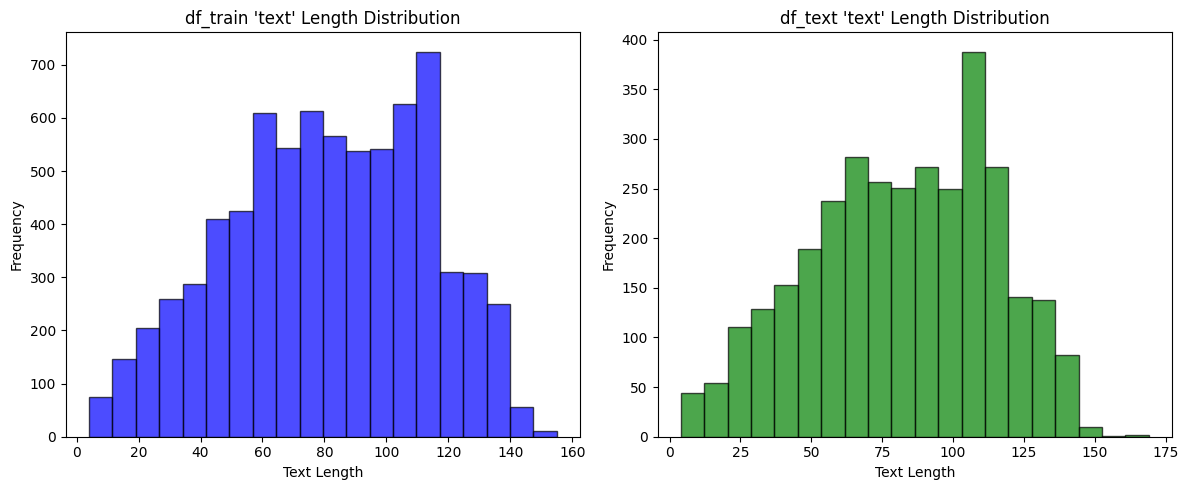

In [147]:
# 각 데이터프레임의 'text' 컬럼 길이 계산
df_train['text_length'] = df_train['text'].apply(len)
df_test['text_length'] = df_test['text'].apply(len)

# 통계 정보 출력
print("📊 df_train 'text' 길이 통계")
print(df_train['text_length'].describe(), "\n")

print("📊 df_test 'text' 길이 통계")
print(df_test['text_length'].describe(), "\n")

# 히스토그램 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_train['text_length'], bins=20, edgecolor='black', alpha=0.7, color='blue')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title("df_train 'text' Length Distribution")

plt.subplot(1, 2, 2)
plt.hist(df_test['text_length'], bins=20, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title("df_text 'text' Length Distribution")

plt.tight_layout()
plt.show()


In [148]:
# Save df to csv
df_train.to_csv('/kaggle/working/df_train.csv', index=False)
df_test.to_csv('/kaggle/working/df_test.csv', index=False)

--------------------
### This is the end of EDA part.  Model building, trainng, result analysis will be continued in the next part.
--------------------